In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import math as mt
import warnings

# 한글출력
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
warnings.filterwarnings(action='ignore') 

from src import crs, PublicPredictor
from src.dbc import utils
from IPython.display import clear_output

In [3]:
# 1. load_excel
data_path = "data/apt_1.xlsx"
xlsx = pd.read_excel(data_path, header=None,
                     skiprows=2, engine="openpyxl")

# 2. data preprocessing
p, m = crs.utils.data_preprocessing(xlsx)

m.set_index("month", inplace=True)

# 3. data init
_month = 1

month_df = pd.DataFrame(m.loc[_month])
month_df.reset_index(inplace=True)

month_df.columns = ['name', 'usage (kWh)']

PUBLIC_PERCENTAGE = 30
APT = crs.utils.get_APT(month_df, PUBLIC_PERCENTAGE)

calc = crs.models.ManagementOffice(
        month=_month,
        households=month_df,
        APT=APT,
        contract="단일계약"
    )
apt = calc.apart

In [4]:
m_15 = utils.data_preprocessing(xlsx)

df = utils.dimension_reduction(m_15)
m_60 = df.copy()

m_60.head()

m_60_1 = m_60[m_60.index.month == 1].copy()
m_60_1.head()

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402,아파트1-103-1201,아파트1-103-801,...,아파트1-102-901,아파트1-103-1905,아파트1-103-503,아파트1-103-1504,아파트1-103-606,아파트1-103-903,아파트1-103-1106,아파트1-103-705,아파트1-103-1505,아파트1-103-406
2019-01-01 00:00:00,0.033,0.000,0.034,0.037,0.062,0.322,0.240,0.295,0.373,0.243,...,0.534,0.188,0.400,0.318,0.420,0.626,0.484,0.289,0.305,0.652
2019-01-01 01:00:00,0.048,0.000,0.033,0.037,0.063,0.185,0.257,0.397,0.257,0.228,...,0.396,0.434,0.355,0.250,0.465,0.409,0.459,0.336,0.332,0.557
2019-01-01 02:00:00,0.032,0.000,0.039,0.036,0.062,0.175,0.384,0.353,0.123,0.141,...,0.194,0.337,0.379,0.274,0.326,0.307,0.405,0.382,0.311,0.491
2019-01-01 03:00:00,0.033,0.000,0.039,0.037,0.062,0.167,0.276,0.488,0.142,0.159,...,0.286,0.263,0.375,0.264,0.336,0.345,0.298,0.291,0.261,0.511
2019-01-01 04:00:00,0.032,0.001,0.033,0.037,0.063,0.197,0.266,0.278,0.190,0.227,...,0.275,0.245,0.310,0.423,0.360,0.364,0.212,0.347,0.294,0.507


## 문서화 공간

### TimeDivision KMeans Fitting

ECV : 40%


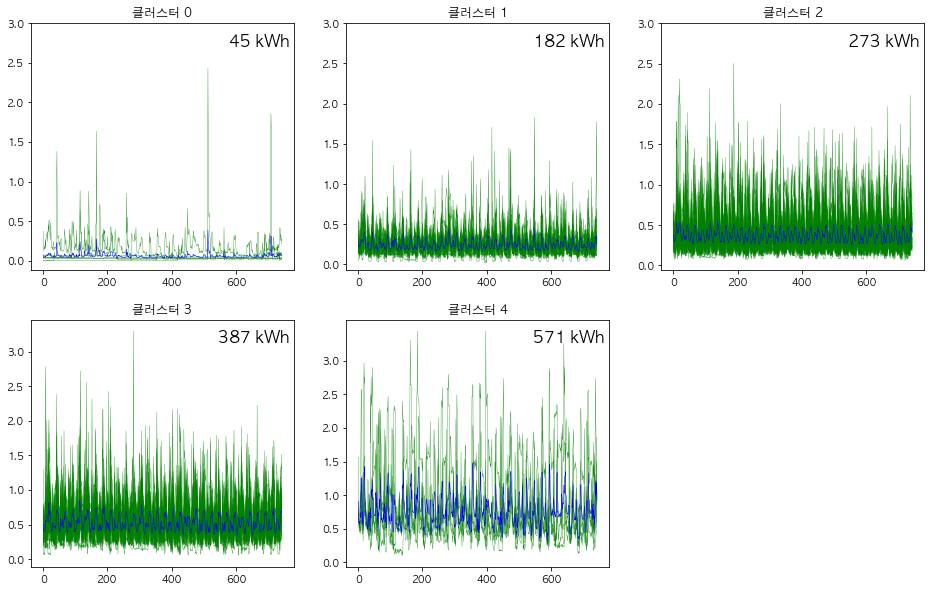

In [5]:
from src import SavingFeedback

sf = SavingFeedback(xlsx, _type="tdkmeans")

sf.select_month(1)
sf.kmeans_run()

clear_output(wait=True)
print("ECV : {}%".format(round(sf.kmeans.kmeans.ecv * 100)))

sf.kmeans.draw_plot()

이상패턴 조정 확인 True
ECV : 40%


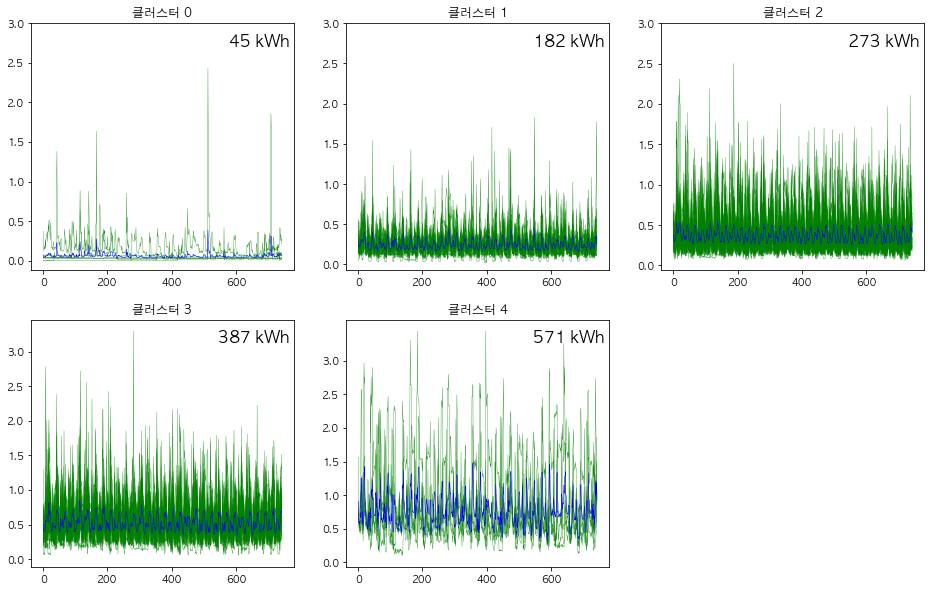

In [6]:
sf.adjust_anomaly()

anomaly = sf.check_anomaly()
clear_output(wait=True)
print("이상패턴 조정 확인", len(anomaly) == 0)
print("ECV : {}%".format(round(sf.kmeans.kmeans.ecv * 100)))

sf.kmeans.draw_plot()

### Cluster Contribution Table

In [7]:
cluster_info = sf.kmeans.cluster_info.copy()
cluster_info.reset_index(inplace=True, drop=True)
cluster_info.index = m_60_1.index[::3]

cluster_info[cluster_info.columns[:8]].head(10)

,아파트1-104-1206,아파트1-104-303,아파트1-104-1307,아파트1-104-1208,아파트1-104-408,아파트1-104-203,아파트1-103-1402,아파트1-103-402
2019-01-01 00:00:00,0,0,0,0,0,1,1,2
2019-01-01 03:00:00,1,0,1,1,1,2,3,3
2019-01-01 06:00:00,0,0,0,0,0,1,1,1
2019-01-01 09:00:00,0,0,0,0,0,0,0,1
2019-01-01 12:00:00,0,0,0,0,0,1,1,2
2019-01-01 15:00:00,0,0,0,0,0,1,1,1
2019-01-01 18:00:00,0,0,0,0,0,1,2,1
2019-01-01 21:00:00,0,0,0,0,0,1,2,3
2019-01-02 00:00:00,0,0,0,0,0,1,1,2
2019-01-02 03:00:00,0,0,0,0,0,1,1,1


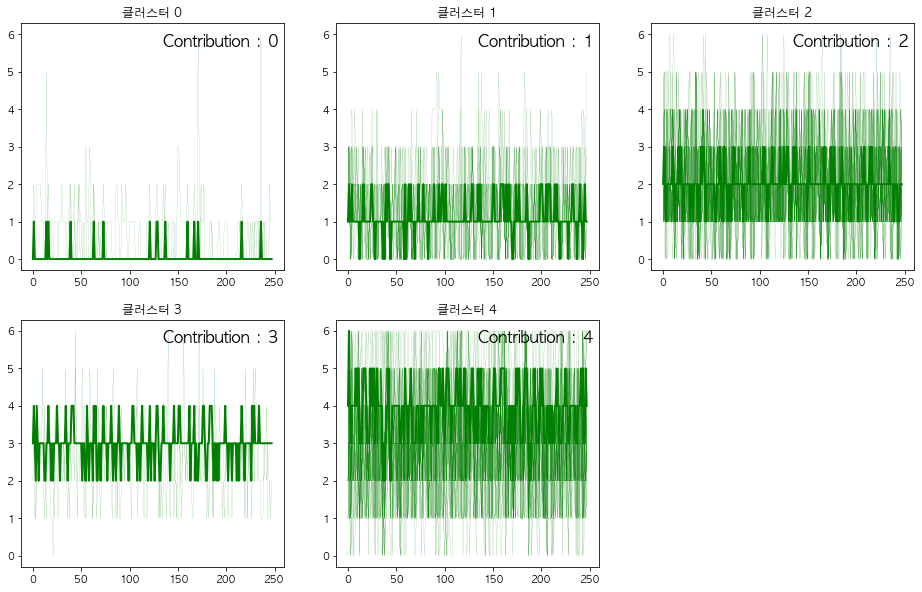

In [8]:
sf.kmeans.draw_cont_plot()

## Contribution Based Comparing

In [68]:
import datetime as dt

time_size = 3

start_time = 3
end_time = start_time + time_size

start_time = dt.time(start_time, 0)
end_time = dt.time(end_time, 0)
sum_df = m_60_1[(m_60_1.index.time >= start_time) &
            (m_60_1.index.time < end_time)]

test_df = pd.DataFrame(np.column_stack([
    m_60_1.columns,
    sum_df.mean(axis=0).values,
    cluster_info[cluster_info.index.time == start_time].mean(axis=0)]),
                      columns=['name', 'usage (kWh)', '평균 기여도'])

test_df

,name,usage (kWh),평균 기여도
0,아파트1-104-1206,0.10272,0.806452
1,아파트1-104-303,0.012204,0.0
2,아파트1-104-1307,0.030108,0.129032
3,아파트1-104-1208,0.048645,0.225806
4,아파트1-104-408,0.052108,0.16129
...,...,...,...
103,아파트1-103-903,0.322409,2.741935
104,아파트1-103-1106,0.241516,1.903226
105,아파트1-103-705,0.239323,2.032258
106,아파트1-103-1505,0.331269,2.903226


In [69]:
anal_df = pd.DataFrame()
for cont_offset in np.arange(0.5, 2, 0.25):
    mins = list()
    for idx,row in test_df.iterrows():
        cont = row['평균 기여도']
        kwh = row['usage (kWh)']
        upper_cont = cont + cont_offset

        _min = test_df[test_df['평균 기여도'] > upper_cont]['usage (kWh)'].min()

        if ~np.isnan(_min):
            _err = _min - kwh
            mins.append(_err)

    anal_df[cont_offset] = [np.array(mins).min()]
    
anal_df = anal_df.T
anal_df.std()

0    0.043638
dtype: float64

(array([ 6.,  8., 18., 25., 20., 12.,  8.,  8.,  1.,  2.]),
 array([0.0, 0.2501, 0.5002, 0.7503, 1.0004, 1.2505, 1.5006, 1.7507,
        2.0008, 2.2508999999999997, 2.501], dtype=object),
 <BarContainer object of 10 artists>)

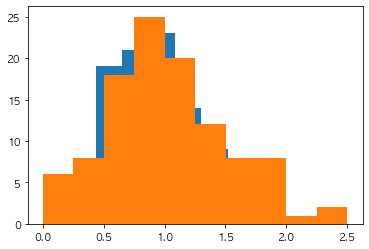

In [28]:
plt.hist(sf.kmeans.kmeans_[1].datas.sum(axis=1))
plt.hist(sf.kmeans.kmeans_[8].datas.sum(axis=1))

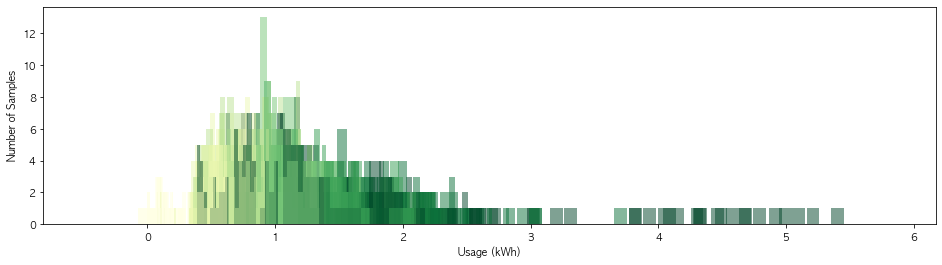

In [59]:
sf.kmeans.hist(division_slot=0)